In [5]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from fig12code import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


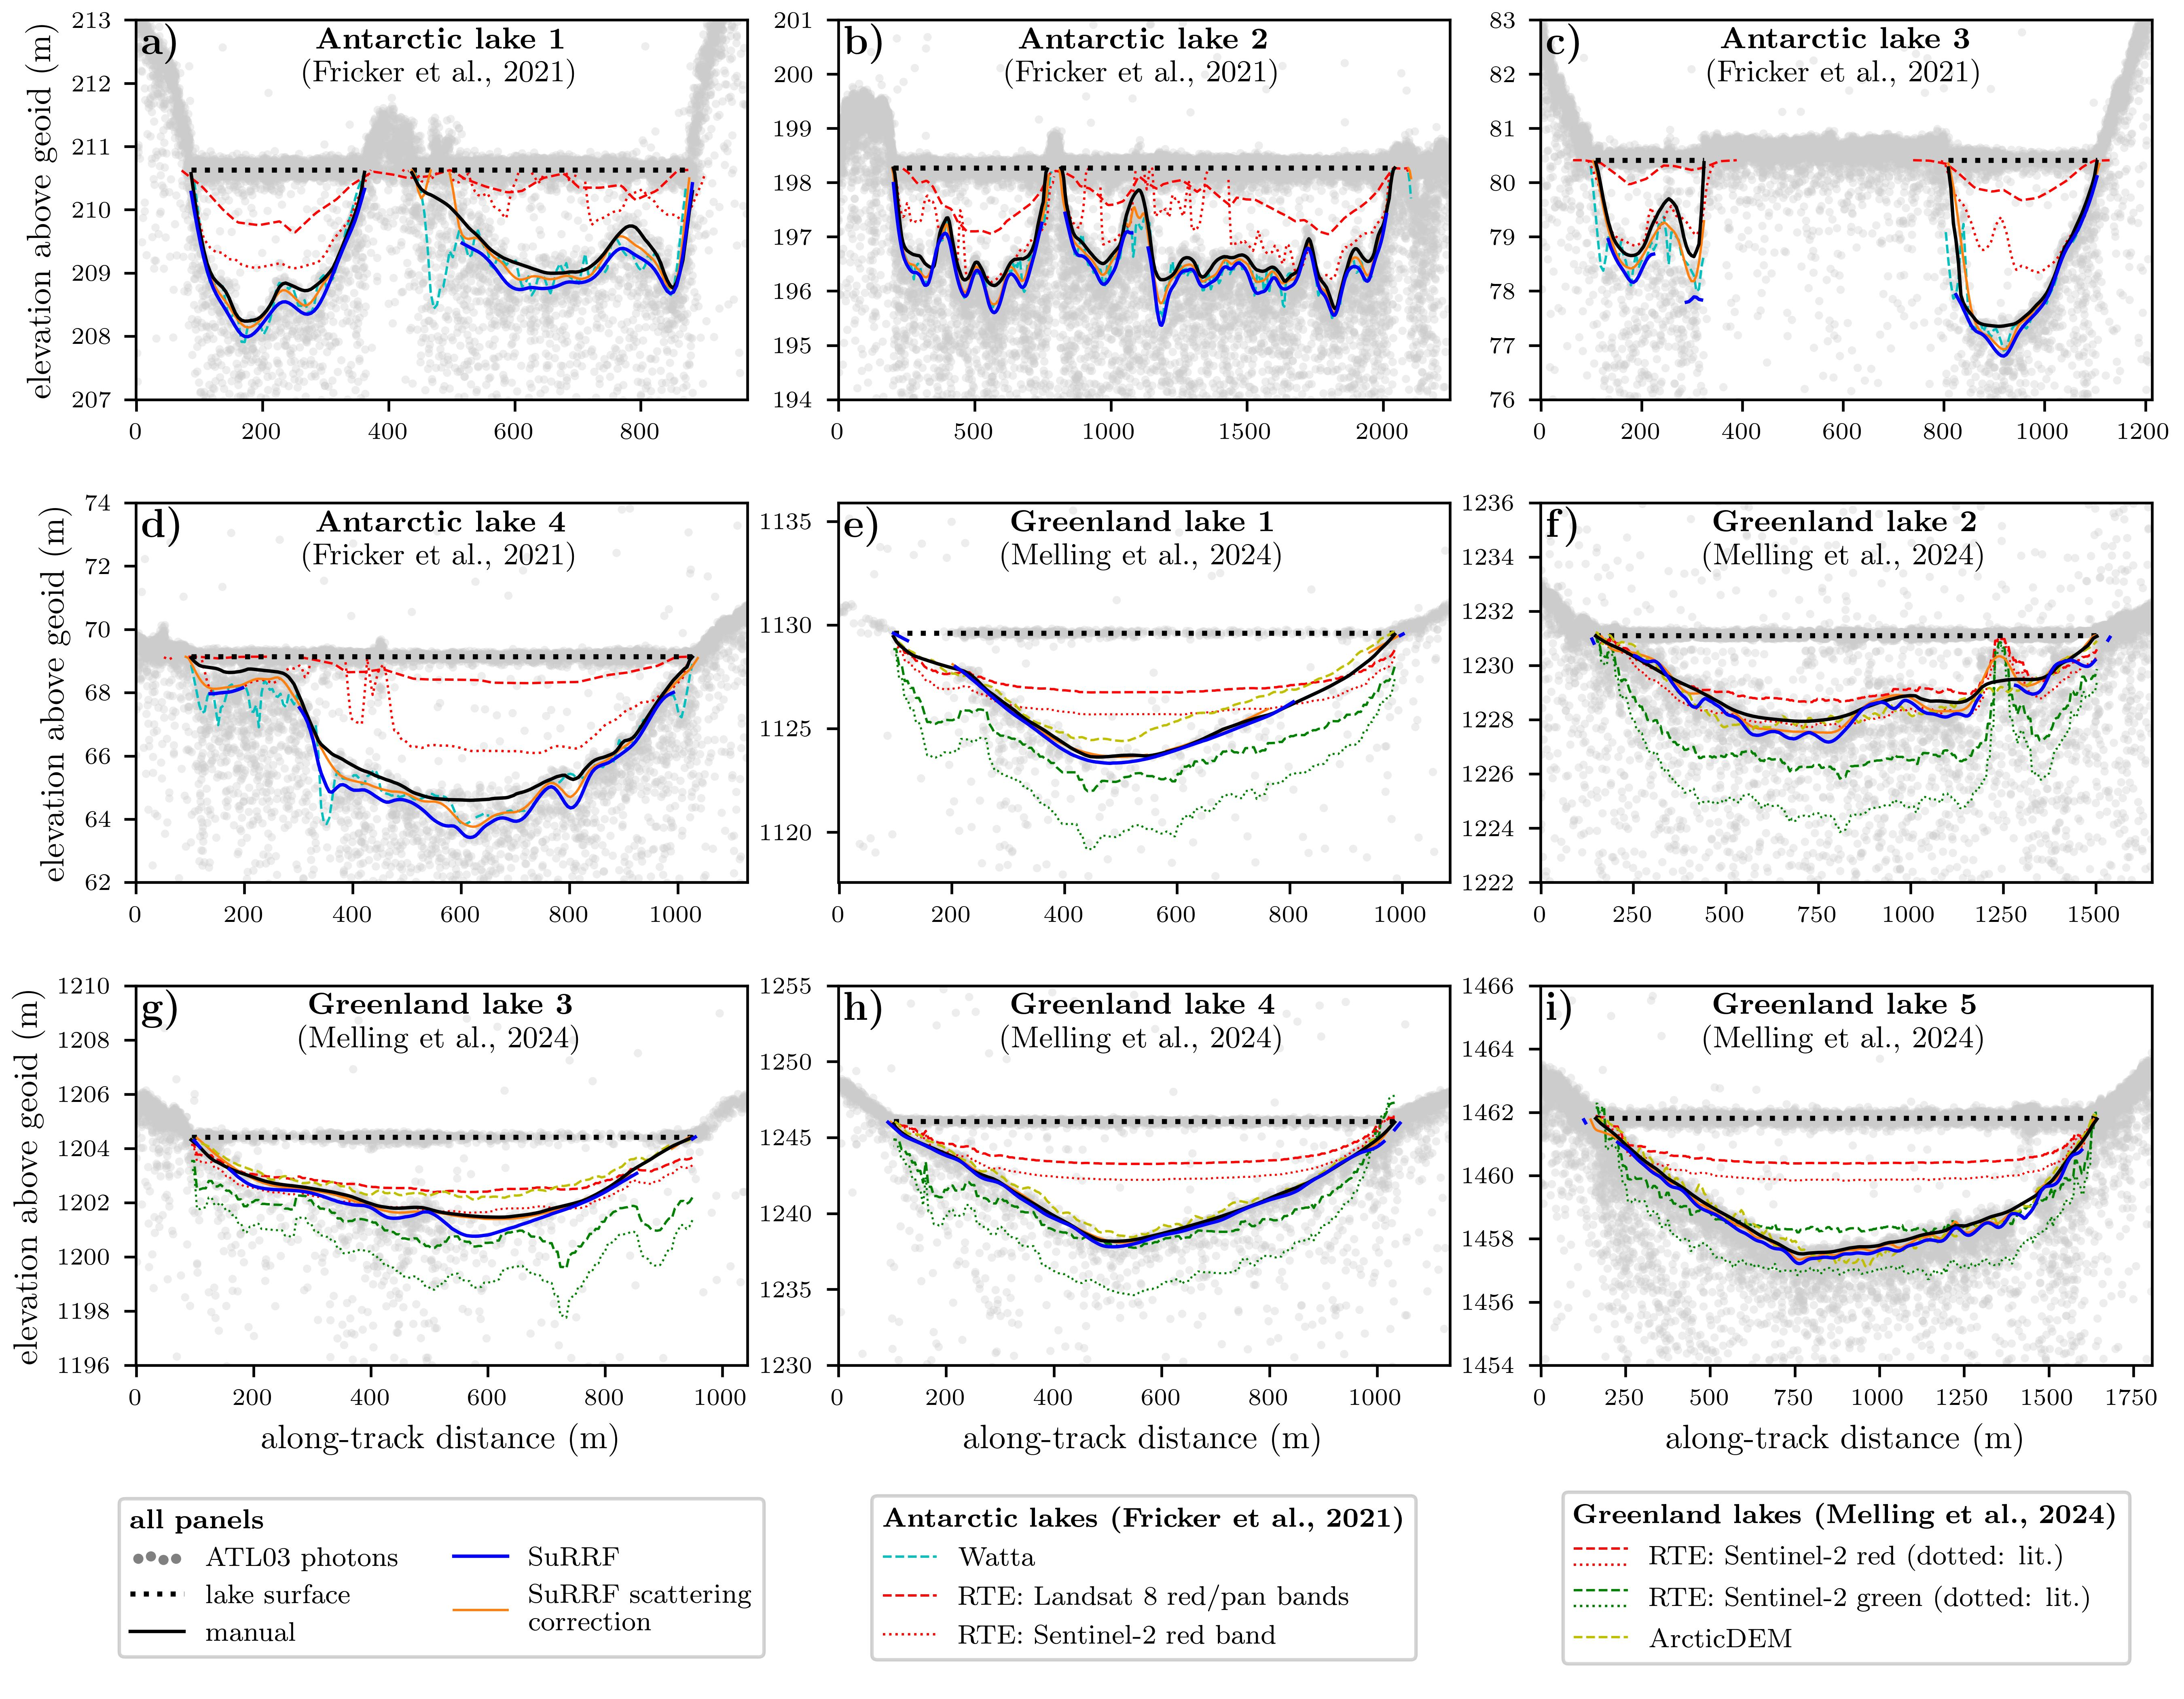

In [26]:
include_lit_melling = True

# input data
df_melling = pd.read_csv('data/data_melling_2024_surrfcorrected.csv',index_col=False)
df_fricker = pd.read_csv('data/data_fricker_2021_surrfcorrected.csv',index_col=False)

conf = 0.2
df_fricker.loc[df_fricker.surrf_corr==0, 'surrf_corr'] = np.nan
df_fricker.loc[df_fricker.surrf_corr_conf<conf, 'surrf_corr'] = np.nan
df_melling.loc[df_melling.surrf_corr==0, 'surrf_corr'] = np.nan
df_melling.loc[df_melling.surrf_corr_conf<conf, 'surrf_corr'] = np.nan

# some plotting settings
plotname = '../figures/fig12-comparison_manual_estimates.jpg'
if include_lit_melling:
    plotname = plotname.replace('.jpg', '_allvalues.jpg')

plt.rcParams.update({
    'font.size': 7,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

fig = plt.figure(figsize=[9,7])
gs = fig.add_gridspec(ncols=3, nrows=11)
axs = []
for i in range(9):
    axs.append(fig.add_subplot(gs[3*int(i/3):3*int(i/3)+3, i%3]))
for i in range(3):
    axs.append(fig.add_subplot(gs[9:, i]))

ref_idx = 1.336
# loop though all the lakes
for iplot, ilake in enumerate(np.hstack((np.arange(1,5), np.arange(1,6)))):
    
    ax = axs[iplot]
    source = 'fricker' if iplot < 4 else 'melling'
    source_txt = 'Fricker et al., 2021' if source=='fricker' else 'Melling et al., 2024'
    dfm = df_fricker if source=='fricker' else df_melling
    lake_file_name = 'data/lake_amery_fricker_%i.h5' % ilake if source=='fricker' else 'data/lake_greenland_melling_%i.h5' % ilake
    location = 'Antarctic' if source=='fricker' else 'Greenland'
    
    selector = dfm.lake_id == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lake_file_name))
    hsurf = lk.surface_elevation
    df = lk.photon_data
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].min()
    xmax = dfi.dist_along_track_m[(dfi.manual>0) & ~np.isnan(dfi.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    df.loc[df.h < hsurf, 'h'] = hsurf - (hsurf - df.loc[df.h < hsurf, 'h']) / ref_idx
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfi.dist_along_track_m -= xoff
    xlim -= xoff

    # remove zero depth values for plotting
    dfi.loc[(dfi.surrf_2024==0) | (dfi.manual==0), 'surrf_2024'] = np.nan
    dfi.loc[dfi.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=6, color=[0.8]*3, alpha=0.35, edgecolors='none')
    p_photons = ax.scatter([-999]*4, [-999]*4, s=4, color='gray', label='ATL03 photons')
    p_manual, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.manual, color='k', label='manual', lw=1, zorder=10)
    p_surrf, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.surrf_2024, color='b', label='SuRRF', lw=1, zorder=11)
    p_surrf_corr, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.surrf_corr, color='C1', label='SuRRF scattering\ncorrection', lw=0.7, zorder=9)

    if source == 'fricker':
        dfi.loc[dfi.RTE_Landsat8_red_pan==0, 'RTE_Landsat8_red_pan'] = np.nan
        dfi.loc[dfi.RTE_Sentinel2_red==0, 'RTE_Sentinel2_red'] = np.nan
        p_watta, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.watta, color='c', ls='--', label='Watta', lw=0.7)
        p_l8, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Landsat8_red_pan, color='r', ls='--', label='RTE: Landsat 8 red/pan bands', lw=0.7)
        p_s2, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.RTE_Sentinel2_red, color='r', ls=':', label='RTE: Sentinel-2 red band', lw=0.7)
        plotted_vals = dfi[['manual', 'surrf_2024', 'watta', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']]

    if source == 'melling':
        p_red, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_red, color='r', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        p_green, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Z_green, color='g', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
        p_dem, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.DEM_zeroed, color='y', ls='--', label='ArcticDEM', lw=0.7, zorder=9)
        plotted_vals = dfi[['manual', 'surrf_2024', 'Z_red', 'Z_green', 'DEM_zeroed']]
        if include_lit_melling:
            p_red_lit, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Red_z_lit, color='r', ls=':', label='RTE: Sentinel-2 red band (lit)', lw=0.6)
            p_green_lit, = ax.plot(dfi.dist_along_track_m, hsurf-dfi.Green_z_lit, color='g', ls=':', label='RTE: Sentinel-2 green band (lit)', lw=0.6)
            plotted_vals = dfi[['manual', 'surrf_2024', 'Z_red', 'Z_green', 'DEM_zeroed', 'Red_z_lit', 'Green_z_lit']]
            # ax.fill_between(dfi.dist_along_track_m, hsurf - dfi.Z_green_max_stdev_mean, hsurf - dfi.Z_green_min_stdev_mean, color='g', alpha=0.1, zorder=0)
            # ax.fill_between(dfi.dist_along_track_m, hsurf - dfi.Z_red_max_stdev_mean, hsurf - dfi.Z_red_min_stdev_mean, color='r', alpha=0.1, zorder=0)
    
    surf = np.ones_like(dfi.manual)*hsurf
    surf[(dfi.manual==0) | np.isnan(dfi.manual)] = np.nan
    p_surface, = ax.plot(dfi.dist_along_track_m, surf, 'k:', label='lake surface')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.15*plotted_vals.max().max(), hsurf+0.6*plotted_vals.max().max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if iplot%3==0:
        ax.set_ylabel('elevation above geoid (m)', fontsize=10)
    if int(iplot/3) == 2:
        ax.set_xlabel('along-track distance (m)', fontsize=10)

    ax.text(0.5, 0.98, '\\textbf{%s lake %s}\n(%s)'%(location,ilake,source_txt),transform=ax.transAxes,ha='center',va='top', fontsize=9)
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + iplot), transform=ax.transAxes, ha='left', va='top', fontsize=12)

# legends
empty_ = ax.scatter([],[],s=1,alpha=0,label=' ')

hdls = [[p_photons, p_surface, p_manual, p_surrf, p_surrf_corr], [p_watta, p_l8, p_s2], [p_red, p_green, p_dem]]
tits = [r'\textbf{all panels}', r'\textbf{Antarctic lakes (Fricker et al., 2021)}', r'\textbf{Greenland lakes (Melling et al., 2024)}']
for i in range(3):
    ax = axs[9+i]
    ax.axis('off')
    ncols = 2 if i==0 else 1
    if i==2 and include_lit_melling:
        pr = Line2D([],[], color='r', ls='--', lw=0.7)
        prl = Line2D([],[], color='r', ls=':', lw=0.7)
        pg = Line2D([],[], color='g', ls='--', lw=0.7)
        pgl = Line2D([],[], color='g', ls=':', lw=0.7)
        hdl_mell = [(pr, prl), (pg, pgl), p_dem]
        labels_melling = ['RTE: Sentinel-2 red (dotted: lit.)', 'RTE: Sentinel-2 green (dotted: lit.)', 'ArcticDEM']
        leg = ax.legend(handles=hdl_mell, labels=labels_melling, loc='center', fontsize=8,
                        handler_map={tuple:HandlerLinesVertical()}, handleheight=1, title=tits[i], title_fontproperties={'size': 8})
    else:
        leg = ax.legend(handles=hdls[i], ncols=ncols, loc='center', scatterpoints=4, fontsize=8, title=tits[i], title_fontproperties={'size': 8})
    leg._legend_box.align = "left"
    ax.add_artist(leg)

fig.tight_layout(pad=0.5)
for ax in axs:
    ylabs = [x for x in ax.get_yticks() if x % 1 == 0]
    ax.set_yticks(ylabs)
fig.tight_layout(pad=0.5)

# save the figure and show plot
plt.close(fig)
fig.savefig(plotname, dpi=600)
display(Image(plotname))
# display(fig)

## show performance stats for each method

In [3]:
# re load the files to make sure the plotting didn't meddle with the dataframes 
# (some weird stuff was happening with missing values that I had removed...)
df_melling = pd.read_csv('data/data_melling_2024_surrfcorrected.csv',index_col=False)
df_fricker = pd.read_csv('data/data_fricker_2021_surrfcorrected.csv',index_col=False)

def getstats(dfsel, stat, verb=False):
    dfsel = dfsel.reset_index(drop=True)
    diffs = (dfsel.manual - dfsel[stat])
    diffs = diffs[~np.isnan(diffs)]
    bias = np.mean(diffs)
    std = np.std(diffs)
    mae = np.mean(np.abs(diffs))
    rmse = np.sqrt(np.mean(diffs**2))
    sel = (~np.isnan(dfsel[stat])) & (~np.isnan(dfsel.manual))
    correl = pearsonr(dfsel.manual[sel], dfsel.loc[sel, stat]).statistic
    percent = int(np.round((dfsel.loc[sel, stat].sum() / dfsel.manual[sel].sum() - 1) * 100))
    if verb:
        print('- mean diff:', bias)
        print('- std diff:', std)
        print('- MAE:', mae)
        print('- RMSE:', rmse)
        print('- correl:', correl)
        
    return pd.DataFrame({'bias': bias, 'std': std, 'mae': mae, 'rmse': rmse, 'R': correl, 'percent': percent}, index=[stat])

print('Antarctic lakes:')
dfsel = df_fricker
stats = ['surrf_2024', 'surrf_corr', 'watta', 'RTE_Sentinel2_red', 'RTE_Landsat8_red_pan']
dfs = []
for stat in stats:
    dfs.append(getstats(dfsel, stat))
display(pd.concat(dfs))

print('Greenland lakes:')
dfsel = df_melling
stats = ['surrf_2024', 'surrf_corr', 'Z_red', 'Red_z_lit', 'Z_green', 'Green_z_lit', 'DEM_zeroed']
dfs = []
for stat in stats:
    dfs.append(getstats(dfsel, stat))
display(pd.concat(dfs))

cols = ['manual', 'surrf_2024', 'surrf_corr']
dfsel = pd.concat((df_fricker[cols], df_melling[cols]))
print('All lakes:')
display(pd.concat((getstats(dfsel, 'surrf_2024'), getstats(dfsel, 'surrf_corr'))))

Antarctic lakes:


,bias,std,mae,rmse,R,percent
surrf_2024,-0.290767,0.246696,0.292267,0.381320,0.989419,17
surrf_corr,-0.133786,0.188966,0.157604,0.231532,0.991338,10
watta,-0.265502,0.363097,0.300445,0.449812,0.941195,15
RTE_Sentinel2_red,0.482435,0.707437,0.554685,0.856278,0.819921,-34
RTE_Landsat8_red_pan,1.029048,0.999333,1.035934,1.434436,0.700852,-73


Greenland lakes:


,bias,std,mae,rmse,R,percent
surrf_2024,-0.228711,0.189272,0.242230,0.296872,0.993696,7
surrf_corr,-0.022943,0.200356,0.141947,0.201665,0.993780,1
Z_red,1.233940,1.278000,1.293234,1.776484,0.773270,-42
Red_z_lit,0.590177,1.168893,0.942629,1.309435,0.772929,-20
Z_green,-1.008922,0.885593,1.146969,1.342460,0.873097,34
Green_z_lit,-2.491145,1.235268,2.527558,2.780592,0.873265,84
DEM_zeroed,0.165671,0.410998,0.343638,0.443133,0.972342,-6


All lakes:


,bias,std,mae,rmse,R,percent
surrf_2024,-0.257156,0.219672,0.265166,0.338209,0.991745,10
surrf_corr,-0.076689,0.202635,0.149539,0.216662,0.993144,3


## Old figure for initial submission

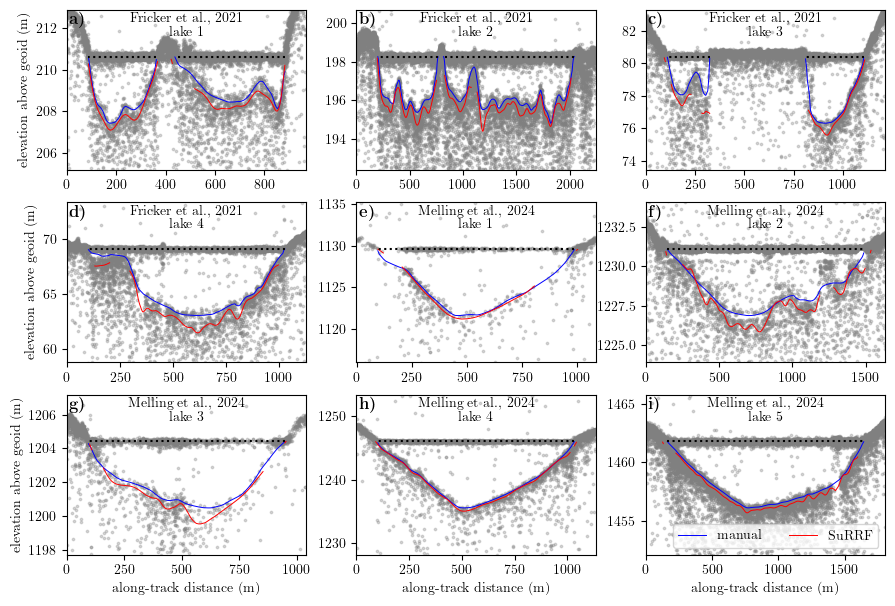

In [4]:
# input data
dfm = pd.read_csv('data/raw/manual_estimates.csv',index_col=False)
lakefns = {
    1: 'data/lake_amery_fricker_1.h5',
    2: 'data/lake_amery_fricker_2.h5',
    3: 'data/lake_amery_fricker_3.h5',
    4: 'data/lake_amery_fricker_4.h5',
    5: 'data/lake_greenland_melling_1.h5',
    6: 'data/lake_greenland_melling_2.h5',
    7: 'data/lake_greenland_melling_3.h5',
    8: 'data/lake_greenland_melling_4.h5',
    9: 'data/lake_greenland_melling_5.h5'
}

# some plotting settings
plotname = '../figures/fig12-comparison_manual_estimates_v0.jpg'
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
conf_threshold = 0.3

# make the figure and axes
fig, axs = plt.subplots(figsize=[9,6], nrows=3, ncols=3)
axs= axs.flatten()

dfm['surrf_2024'] = np.nan # initialize column for surrf
dfds = []
# loop though all the lakes
for ilake in np.unique(dfm.pond):
    ax = axs[ilake-1]
    selector = dfm.pond == ilake
    dfi = dfm[selector].copy()
    lk = dictobj(read_melt_lake_h5(lakefns[ilake]))
    hsurf = lk.surface_elevation
    surf = np.ones_like(dfi.manual)*hsurf
    surf[dfi.manual==0] = np.nan
    df = lk.photon_data
    dfd = lk.depth_data.sort_values(by='lat')
    man_bed = hsurf - dfi.manual
    man_bed[dfi.manual == 0] = np.nan
    fit_bed = dfd.h_fit_bed.copy()
    fit_bed[fit_bed > hsurf] = np.nan
    fit_bed[(dfd.conf < conf_threshold)] = np.nan
    
    depth = dfd.depth.copy()
    depth[(dfd.conf < conf_threshold)] = np.nan
    depth=depth*1.336
    depth_interp = np.interp(dfi.lat, dfd.lat, depth, left=np.nan, right=np.nan)
    dfm.loc[selector, 'surrf_2024'] = depth_interp
    dfd['surrf'] = depth
    dfd['manual'] = np.interp(dfd.lat, dfi.lat, dfi.manual, left=np.nan, right=np.nan)
    dfd['lake_id'] = ilake
    dfd['granule_id'] = dfi.granule_id.iloc[0]
    dfd['gtx'] = dfi.gtx.iloc[0]
    dfd['manual_source'] = dfi.source.iloc[0]
    dfds.append(dfd)

    dfd.loc[(dfd.conf < conf_threshold), 'depth'] = np.nan
    afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    xmin = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].min()
    xmax = dfd.xatc[(dfd.manual>0) & ~np.isnan(dfd.manual)].max()
    xrange = xmax-xmin
    fac = 0.11
    xlim = np.array([xmin-fac*xrange, xmax+fac*xrange])
    df = df[(df.xatc > xlim[0]) & (df.xatc < xlim[1])].copy()
    xoff = df.xatc.min()
    df.xatc -= xoff
    dfd.xatc -= xoff
    xlim -= xoff
    dfd.loc[dfd.depth==0, 'depth'] = np.nan
    dfd.loc[dfd.manual==0, 'manual'] = np.nan
    ax.scatter(df.xatc[~afterpulse], df.h[~afterpulse], s=3, c='gray', alpha=0.3)
    p_manual, = ax.plot(dfd.xatc, hsurf-dfd.manual, color='b', label='manual', lw=0.7)
    p_surrf, = ax.plot(dfd.xatc, hsurf-dfd.depth*1.336, color='r', label='SuRRF', lw=0.7)
    surf = np.ones_like(dfd.manual)*hsurf
    surf[(dfd.manual==0) | np.isnan(dfd.manual)] = np.nan
    ax.plot(dfd.xatc, surf, 'k:')
    ax.set_xlim(xlim)
    ax.set_ylim([hsurf-1.7*dfi.manual.max(), hsurf+0.7*dfi.manual.max()])
    ax.ticklabel_format(useOffset=False, style='plain')
    if (ilake-1)%3==0:
        ax.set_ylabel('elevation above geoid (m)')
    if int((ilake-1)/3) == 2:
        ax.set_xlabel('along-track distance (m)')
    if ilake==9:
        ax.legend(handles=[p_manual, p_surrf], ncols=2, loc='lower right')

    source = 'Fricker et al., 2021' if ilake < 5 else 'Melling et al., 2024'
    lakenr = ilake if ilake < 5 else ilake-4 
    ax.text(0.5, 0.98, '%s\nlake %s'%(source,lakenr),transform=ax.transAxes,ha='center',va='top')
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + ilake - 1), transform=ax.transAxes, ha='left', va='top', fontsize=12)

fig.tight_layout(pad=0.5)

# save the figure and show plot
# fig.savefig(plotname, dpi=600)
plt.close(fig)
# display(Image(plotname))
display(fig)